In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [2]:
train = pd.read_csv('data/train_dropped_290_without_nans.csv')
test = pd.read_csv('data/test_dropped_290_without_nans.csv')

print(train.shape, test.shape)

(2838, 293) (939, 293)


In [3]:
X_train = train.drop(['0','1','2'], axis=1)
y_train = pd.read_csv('data/y_train.csv')['Culture']

X_test = test.drop(['0','1','2'], axis=1)

In [4]:
y_train

0        4
1       17
2        2
3        4
4        4
        ..
2833     4
2834     4
2835     4
2836     5
2837     7
Name: Culture, Length: 2838, dtype: int64

In [5]:
X_tt, X_tv, y_tt, y_tv = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [6]:
EPOCHS = 300
BATCH_SIZE = 128
LEARNING_RATE = 0.001

num_features=290
num_targets=29
hidden_size=784


In [7]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, 1160))
        
        self.batch_norm2 = nn.BatchNorm1d(1160)
        self.dropout2 = nn.Dropout(0.4)
        self.dense2 = nn.utils.weight_norm(nn.Linear(1160, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(0.4)
        self.dense4 = nn.Linear(hidden_size, num_targets)
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.dense4(x)
        
        return x

In [8]:
class MoADataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        
        return self.features[idx],self.targets[idx]
    
class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.features[idx]

In [9]:
train_dataset = MoADataset(torch.from_numpy(X_tt.values).float(), torch.from_numpy(y_tt.values).long())
val_dataset = MoADataset(torch.from_numpy(X_tv.values).float(), torch.from_numpy(y_tv.values).long())
test_dataset = TestDataset(torch.from_numpy(X_test.values).float())

In [10]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [11]:
model = Model(num_features, num_targets, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

Model(
  (batch_norm1): BatchNorm1d(290, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=290, out_features=1160, bias=True)
  (batch_norm2): BatchNorm1d(1160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (dense2): Linear(in_features=1160, out_features=784, bias=True)
  (batch_norm3): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=784, out_features=784, bias=True)
  (batch_norm4): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.4, inplace=False)
  (dense4): Linear(in_features=784, out_features=29, bias=True)
)


In [12]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [13]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch) 
        
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    if val_epoch_loss/len(val_loader) <0.24:
        break

Begin training.


Epoch 001: | Train Loss: 1.37762 | Val Loss: 1.10665 | Train Acc: 88.889| Val Acc: 100.000
Epoch 002: | Train Loss: 0.94268 | Val Loss: 0.76280 | Train Acc: 100.000| Val Acc: 100.000
Epoch 003: | Train Loss: 0.84985 | Val Loss: 0.65437 | Train Acc: 100.000| Val Acc: 100.000
Epoch 004: | Train Loss: 0.78615 | Val Loss: 0.61365 | Train Acc: 100.000| Val Acc: 100.000
Epoch 005: | Train Loss: 0.75955 | Val Loss: 0.59933 | Train Acc: 100.000| Val Acc: 100.000
Epoch 006: | Train Loss: 0.72625 | Val Loss: 0.58448 | Train Acc: 100.000| Val Acc: 100.000
Epoch 007: | Train Loss: 0.71706 | Val Loss: 0.56491 | Train Acc: 100.000| Val Acc: 100.000
Epoch 008: | Train Loss: 0.68702 | Val Loss: 0.53390 | Train Acc: 100.000| Val Acc: 100.000
Epoch 009: | Train Loss: 0.66283 | Val Loss: 0.51534 | Train Acc: 100.000| Val Acc: 100.000
Epoch 010: | Train Loss: 0.63812 | Val Loss: 0.52262 | Train Acc: 100.000| Val Acc: 100.000
Epoch 011: | Train Loss: 0.62631 | Val Loss: 0.51706 | Train Acc: 100.000| Val Ac

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

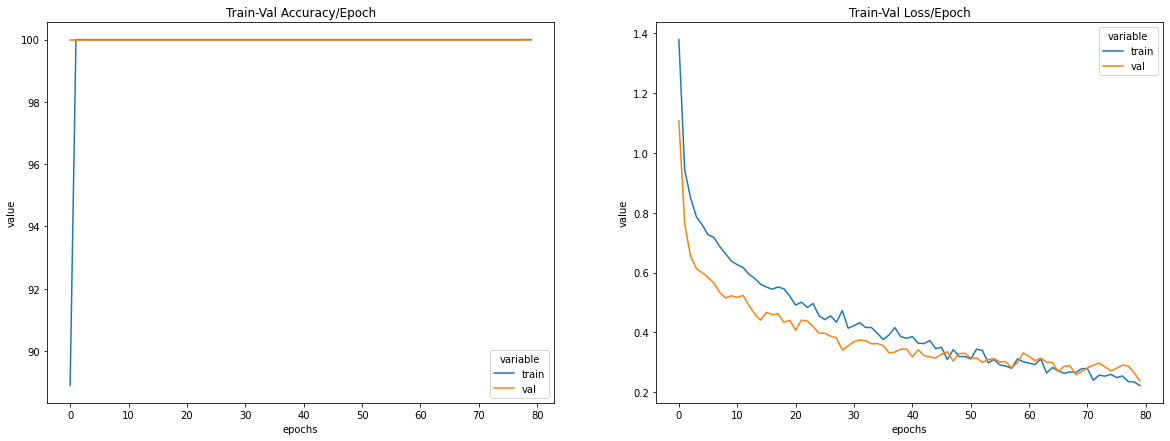

In [15]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [16]:
y_pred_list = []
y_pred_1_list = []

with torch.no_grad():
    model.eval()
    for X_batch,_  in val_loader:
        X_batch = X_batch
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_1_list.append(y_pred_tags.numpy())
#y_pred_list = [a.squeeze().tolist() for a in y_pred_1_list]

In [17]:
preds=[]
for i in y_pred_1_list:
    for j in i:
        preds.append(j)

In [18]:
f1_score(preds,y_tv.values , average='weighted')

0.9101253075605308

In [19]:
y_pred_list = []
y_pred_1_list = []

with torch.no_grad():
    model.eval()
    for X_batch in test_loader:
        X_batch = X_batch
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_1_list.append(y_pred_tags.numpy())
#y_pred_list = [a.squeeze().tolist() for a in y_pred_1_list]
preds=[]
for i in y_pred_1_list:
    for j in i:
        preds.append(j)

In [20]:
pd.Series(preds).to_csv('preds/torch_missf_290.csv', index=False, header=['Culture'])

In [21]:
pd.Series(preds)

0       8
1      12
2      10
3       7
4       4
       ..
934     3
935    21
936    10
937    12
938     4
Length: 939, dtype: int64